# Train a tree based model for regression task: predict delay difference

In [1]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import sklearn
from sklearn.inspection import PartialDependenceDisplay
# from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [2]:
import sys
import logging
import datetime

nblog = open("./logs/tree_pdp_shap_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
%%time

df_traffic = pd.read_csv('output/austin_2022_GP_10min_interval_delaydifference_with_features_forML2.csv')
df_traffic = df_traffic.rename(columns={"miles": "segment_length"})

df_traffic['minutes_since_midnight'] = df_traffic['hour_min'].apply(lambda x: int(x[:2]) * 60 + int(x[3:]))

print(df_traffic.date.unique())
print('unique road segments (samples):',df_traffic.tmc_code.unique().shape[0])
print('total observations: ',df_traffic.shape[0])
df_traffic.head(2)

['2022-10-21' '2022-10-22' '2022-10-23']
unique road segments (samples): 3221
total observations:  1388251
CPU times: user 3.98 s, sys: 402 ms, total: 4.38 s
Wall time: 5.21 s


tmc_code hour_min  delay_baseline  delay_focus  delay_difference        date         intersection  start_latitude  start_longitude  end_latitude  end_longitude  segment_length  airbnb_count  distance_to_venue_centroid  distance_to_Shuttle_Waterloo_Park  distance_to_Shuttle_Barton_Creek_Square  distance_to_Shuttle_Expo_Center  segment_bearing                                       osm_id       road_type  oneway       lanes maxspeed  lanes_mean  minutes_since_midnight  no_devices
0  112+04760  00:00   -1.77926        -2.22226     -0.44300           2022-10-21  US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402      0.29287          49           26.64241                    7.39988                            14.41580                                 10.33789                         19.79829          [122981397, 1012363973]66847798019339769835  secondary_link  True    ['1', '2']  55 mph  1.50000      0                      0.00000    
1  112+04760  00:10   -1.30941        -2.43440     -1.12499           2022-10-21  US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402      0.29287          49           26.64241                    7.39988                            14.41580                                 10.33789                         19.79829          [122981397, 1012363973]66847798019339769835  secondary_link  True    ['1', '2']  55 mph  1.50000      10                     0.00000

In [4]:
# because the event usually begins in the morning after 10, people arrive typically around that time, so we want to only focus on after 930
df_traffic = df_traffic[df_traffic['minutes_since_midnight']>=540]
print(df_traffic.shape[0])
df_traffic = pd.get_dummies(df_traffic, columns=['date'], prefix='date')

866449


In [5]:
df_traffic.columns

Index(['tmc_code', 'hour_min', 'delay_baseline', 'delay_focus', 'delay_difference', 'intersection', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'segment_length', 'airbnb_count', 'distance_to_venue_centroid', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center', 'segment_bearing', 'osm_id', 'road_type', 'oneway', 'lanes', 'maxspeed', 'lanes_mean', 'minutes_since_midnight', 'no_devices', 'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23'], dtype='object')

In [6]:
# df_traffic_oneday = df_traffic[df_traffic['date']=='2022-10-22']
# df_traffic['distance_to_Uber_DelValle_HighSchool'] = df_traffic['distance_to_venue_centroid']
df_traffic.loc[df_traffic.road_type=="motorway_link", 'road_type'] = 'motorway'
df_traffic.loc[df_traffic.road_type=="primary_link", 'road_type'] = 'primary'
df_traffic.loc[df_traffic.road_type=="secondary_link", 'road_type'] = 'secondary'
df_traffic.loc[df_traffic.road_type=="trunk_link", 'road_type'] = 'trunk'
df_traffic.loc[df_traffic.road_type=="tertiary_link", 'road_type'] = 'tertiary'
df_traffic['road_type'].value_counts()

secondary       334905
motorway        176464
tertiary        162745
primary         122126
residential     35508 
trunk           24479 
unclassified    10222 
Name: road_type, dtype: int64

In [7]:
# df_traffic['road_type'].unique()

In [8]:
import re

def process_max_speed(value):
    if isinstance(value, str):
        # Extract all numeric values from the string
        numbers = list(map(int, re.findall(r'\d+', value)))
        if numbers:
            return max(numbers)  # Return the maximum value
    return None

# Apply the function to the max_speed column
df_traffic['max_speed'] = df_traffic['maxspeed'].apply(process_max_speed)

In [9]:
df_traffic.max_speed.value_counts()

30.00000    83659
65.00000    59180
35.00000    55952
45.00000    48958
60.00000    40081
40.00000    32280
55.00000    25555
70.00000    25017
75.00000    20713
50.00000    14526
80.00000    14257
25.00000    11029
85.00000    1076 
Name: max_speed, dtype: int64

In [10]:
df_road_embeddings = pd.read_csv('output/network_embeddings.csv')
df_road_embeddings.head()

tmc_code  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  embedding_55  embedding_56  embedding_57  embedding_58  embedding_59  embedding_60  embedding_61  embedding_62  embedding_63
0  112P13033 0.89394      -0.70949     0.27297      0.94302      0.52385      0.21081      0.19544      -1.11029     -0.34201     -0.63806     0.61514       0.08389       0.20198       -0.60907      -1.18846      0.40890       -1.35415      0.45196       -0.02265      0.01204       0.05474       -0.15486      -0.30685      -0.51994      -0.40198      1.02627       -0.30101      0.12434       -0.53349      -0.29412      0.40588       0.99231       -0.38362      0.02875       0.98902       0.53337       -0.69483      0.10666       0.00286       -0.30354      -0.18832      -0.04690      -0.95317      -0.48840      -0.55021      0.02758       -0.91661      -0.29719      -0.41314      0.79062       0.83682       -0.54500      -0.49934      -0.27126      0.14315       -0.27732      -0.00200      -0.43380      -0.55204      0.99135       -0.46165      0.90756       0.21971       0.69996      
1  112+08908 0.95594      -0.09309     0.68374      -0.25662     -0.40958     -0.69403     0.24038      -1.07453     0.11010      0.91076      -1.29390      0.68600       -0.25977      -0.23630      0.42559       0.60496       -0.73102      0.16498       -0.40871      0.50723       0.37721       0.22079       -0.88531      -0.90539      -0.73308      0.01204       -0.34629      0.40196       -0.50550      0.43088       0.71081       0.12564       -0.62371      0.46146       -0.49235      0.65895       -0.00663      -0.31751      -0.02638      -0.31744      0.01322       0.17740       -0.23827      -0.04222      0.21908       0.81301       -0.56844      -0.80706      0.92946       0.32437       0.75485       -0.37074      -0.11247      -0.39159      1.35846       0.17667       0.02355       -1.27719      0.58497       0.47358       -0.55544      0.64552       -0.01274      0.70810      
2  112+16538 0.20269      -0.16160     -0.02221     0.63865      0.49279      -1.34900     -0.63917     -0.18361     0.43124      0.21794      -0.23086      -0.05830      0.35884       -0.01433      0.49366       -0.13151      -1.23072      0.43204       -0.54838      0.91951       0.33172       -0.90362      -0.06825      -0.43013      -0.18407      -0.50543      -0.87509      -0.17228      0.29572       0.03202       0.30549       -0.68464      0.75256       0.16532       -0.38300      0.15605       -0.25988      -0.95127      0.00084       -0.62071      0.16747       0.59019       -0.39169      -0.94457      0.23689       0.17613       -0.63443      0.24737       -0.02575      0.37269       1.12009       0.04709       -1.14419      -0.95015      0.23540       -0.22203      -0.06967      -0.88440      0.36051       0.17107       -0.21150      0.79029       -0.67897      -0.21528     
3  112+16539 0.29767      -0.12916     0.19061      0.39332      0.21330      -1.40112     -0.76361     -0.45503     0.50266      0.14276      -0.27168      -0.19807      0.22116       -0.01345      0.38678       -0.07689      -1.26219      0.48296       -0.76492      0.86878       0.28393       -0.82666      -0.34225      -0.60020      0.02567       -0.52546      -1.07706      -0.27753      0.39612      

In [11]:
df_traffic = df_traffic.merge(df_road_embeddings, how='left')
print(df_traffic.shape[0])
df_traffic.head(2)

866449


tmc_code hour_min  delay_baseline  delay_focus  delay_difference         intersection  start_latitude  start_longitude  end_latitude  end_longitude  segment_length  airbnb_count  distance_to_venue_centroid  distance_to_Shuttle_Waterloo_Park  distance_to_Shuttle_Barton_Creek_Square  distance_to_Shuttle_Expo_Center  segment_bearing                                       osm_id  road_type  oneway       lanes maxspeed  lanes_mean  minutes_since_midnight  no_devices  date_2022-10-21  date_2022-10-22  date_2022-10-23  max_speed  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  embedding_30  embedding_31  embedding_32  embedding_33  \
0  112+04760  09:00   -1.30941        -0.54871     0.76071            US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402      0.29287          49           26.64241                    7.39988                            14.41580                                 10.33789                         19.79829          [122981397, 1012363973]66847798019339769835  secondary  True    ['1', '2']  55 mph  1.50000      540                    3.00000      1                0                0               55.00000   0.80788      -0.30878     0.48830      0.40444      -0.19644     -0.63592     -0.05096     -0.96207     -0.26387     0.54659      -1.03205      -0.57319      0.58703       -0.90266      0.39712       0.64467       0.02475       -0.13640      -0.42769      0.39307       0.45515       0.69224       0.02814       -0.87651      -0.46587      -0.28346      -0.03728      -0.89838      -0.87812      -0.60183      0.24631       -0.66729      0.74725       -0.08435        
1  112+04760  09:10   0.00000         -1.77926     -1.77926           US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402      0.29287          49           26.64241                    7.39988                            14.41580                                 10.33789                         19.79829          [122981397, 1012363973]66847798019339769835  secondary  True    ['1', '2']  55 mph  1.50000      550                    8.00000      1                0                0               55.00000   0.80788      -0.30878     0.48830      0.40444      -0.19644     -0.63592     -0.05096     -0.96207     -0.26387     0.54659      -1.03205      -0.57319      0.58703       -0.90266      0.39712       0.64467       0.02475       -0.13640      -0.42769      0.39307       0.45515       0.69224       0.02814       -0.87651      -0.46587      -0.28346      -0.03728      -0.89838      -0.87812      -0.60183      0.24631       -0.66729      0.74725       -0.08435        

   embedding_34  embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  embedding_55  embedding_56  embedding_57  embedding_58  embedding_59  embedding_60  embedding_61  embedding_62  embedding_63  
0 0.21258       0.50216       -0.85987      -0.10462      0.10216       -0.61296      0.70476       -0.07447      -0.44610      -1.25291      -0.56601      0.08196       0.06211       0.14970       0.23362       -0.72179      0.71536       0.29920       -0.47497      -0.78599      -0.12997      -0.19213      -0.19580      -0.42946      -1.18347      0.54779       -0.78096      0.16931       0.24326       -0.44661       
1 0.21258       0.50216       -0.85987      -0.10462      0.10216       -0.61296      0.70476       -0.07447      -0.44610      -1.25291      -0.56601     

# Descriptive statistics (optional)

In [13]:
df_traffic.columns

Index(['tmc_code', 'hour_min', 'delay_baseline', 'delay_focus', 'delay_difference', 'intersection', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
       ...
       'mean_embedding_118', 'mean_embedding_119', 'mean_embedding_120', 'mean_embedding_121', 'mean_embedding_122', 'mean_embedding_123', 'mean_embedding_124', 'mean_embedding_125', 'mean_embedding_126', 'mean_embedding_127'], dtype='object', length=157)

In [146]:
df_traffic.max_speed.describe().apply(lambda x: f"{x:.2f}")
# df_traffic.segment_bearing.describe()

count    432283.00
mean     48.95    
std      16.09    
min      25.00    
25%      35.00    
50%      45.00    
75%      65.00    
max      85.00    
Name: max_speed, dtype: object

In [170]:
df_traffic['road_type'].value_counts(normalize=True).apply(lambda x: f"{x*100:.2f}").sort_index(ascending=True)

motorway        20.37
primary         14.10
residential     4.10 
secondary       38.65
tertiary        18.78
trunk           2.83 
unclassified    1.18 
Name: road_type, dtype: object

# Preparing training data

In [12]:
# df_test = df_traffic[['minutes_since_midnight',   'segment_length',
#                 'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23',
#                 'airbnb_count',  'distance_to_venue_centroid', 'oneway', 'lanes_mean','road_type',
#             'distance_to_Shuttle_Waterloo_Park', 
#                ]].copy() 
# df_test_cor = df_test.corr()
# pd.DataFrame(np.linalg.inv(df_test.corr().values), index = df_test_cor.index, columns=df_test_cor.columns)

feature_names = ['minutes_since_midnight',   'segment_length','segment_bearing', 'oneway', 'lanes_mean','road_type', 'max_speed',
                'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23',
                'airbnb_count',  'distance_to_venue_centroid', 'no_devices'
               ]

feature_names.extend([f"embedding_{i}" for i in range(64)])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare input features and labels for the model

X = df_traffic[feature_names].copy() 
# 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center',
# 'start_latitude', 'start_longitude',

X['road_type'] = X['road_type'].astype('category')

y = df_traffic['delay_difference'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Total sample size:', X.shape[0])
print('Total training set size:', X_train.shape[0])
print('Total test set size:', X_test.shape[0])

Total sample size: 866449
Total training set size: 606514
Total test set size: 259935


In [16]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical='True')
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical='True')

In [26]:
# %%time
# # check VIF
# df_cor = X.corr()
# pd.DataFrame(np.linalg.inv(X.corr().values), index = df_cor.index, columns=df_cor.columns)

# Hyperparameter tuning using optuna

In [ ]:
%%time
# %pip install optuna
## this step took 25min to finish

import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from lightgbm import LGBMRegressor

def objective(trial):
    # Define hyperparameters to optimize
    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 1e-1, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
    }
    
    
    # Initialize CatBoostRegressor with the suggested hyperparameters
    model = LGBMRegressor(**params, categorical_feature=['road_type'])
    
    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rmse_scorer = make_scorer(mean_squared_error, squared=False)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=rmse_scorer)

    return scores.mean()

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-01-28 18:16:35,775] A new study created in memory with name: no-name-e014fd49-24c6-472e-a62b-f1a9840b7b14


[LightGBM] [Warning] feature_fraction is set=0.7380546130697718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7380546130697718
[LightGBM] [Warning] lambda_l1 is set=2.360301181312583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.360301181312583
[LightGBM] [Warning] bagging_fraction is set=0.6370602699809663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6370602699809663
[LightGBM] [Warning] lambda_l2 is set=7.827310096271281, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.827310096271281
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7380546130697718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7380546130697718
[LightGBM] [Warning] lambda_l1 is set=2.360301181312583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.360301181312583
[LightGBM] [Warning] bagging_fraction is se

[I 2025-01-28 18:17:04,370] Trial 0 finished with value: 13.830198668794186 and parameters: {'num_leaves': 35, 'max_depth': 6, 'learning_rate': 0.09591653107388348, 'n_estimators': 371, 'min_child_samples': 15, 'min_child_weight': 0.005053792361418142, 'lambda_l1': 2.360301181312583, 'lambda_l2': 7.827310096271281, 'feature_fraction': 0.7380546130697718, 'bagging_fraction': 0.6370602699809663, 'bagging_freq': 3}. Best is trial 0 with value: 13.830198668794186.


[LightGBM] [Warning] feature_fraction is set=0.6310278788169681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6310278788169681
[LightGBM] [Warning] lambda_l1 is set=7.2216033683661305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.2216033683661305
[LightGBM] [Warning] bagging_fraction is set=0.7602275140854272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602275140854272
[LightGBM] [Warning] lambda_l2 is set=4.0217831491980185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0217831491980185
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6310278788169681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6310278788169681
[LightGBM] [Warning] lambda_l1 is set=7.2216033683661305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.2216033683661305
[LightGBM] [Warning] bagging_fracti

[I 2025-01-28 18:17:41,687] Trial 1 finished with value: 14.27065377332627 and parameters: {'num_leaves': 133, 'max_depth': 9, 'learning_rate': 0.02567273703575534, 'n_estimators': 323, 'min_child_samples': 62, 'min_child_weight': 0.010042626015510496, 'lambda_l1': 7.2216033683661305, 'lambda_l2': 4.0217831491980185, 'feature_fraction': 0.6310278788169681, 'bagging_fraction': 0.7602275140854272, 'bagging_freq': 10}. Best is trial 0 with value: 13.830198668794186.


[LightGBM] [Warning] feature_fraction is set=0.844720451115162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.844720451115162
[LightGBM] [Warning] lambda_l1 is set=6.911380606629258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.911380606629258
[LightGBM] [Warning] bagging_fraction is set=0.9683970596403054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9683970596403054
[LightGBM] [Warning] lambda_l2 is set=7.4045881567957395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.4045881567957395
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.844720451115162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.844720451115162
[LightGBM] [Warning] lambda_l1 is set=6.911380606629258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.911380606629258
[LightGBM] [Warning] bagging_fraction is set=

[I 2025-01-28 18:18:24,728] Trial 2 finished with value: 12.90625281220261 and parameters: {'num_leaves': 58, 'max_depth': 9, 'learning_rate': 0.22133738111083043, 'n_estimators': 528, 'min_child_samples': 45, 'min_child_weight': 0.07327832737824576, 'lambda_l1': 6.911380606629258, 'lambda_l2': 7.4045881567957395, 'feature_fraction': 0.844720451115162, 'bagging_fraction': 0.9683970596403054, 'bagging_freq': 5}. Best is trial 2 with value: 12.90625281220261.


[LightGBM] [Warning] feature_fraction is set=0.6612139331408367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6612139331408367
[LightGBM] [Warning] lambda_l1 is set=7.8229848870612795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8229848870612795
[LightGBM] [Warning] bagging_fraction is set=0.6817494303400949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6817494303400949
[LightGBM] [Warning] lambda_l2 is set=7.019135317478325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.019135317478325
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6612139331408367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6612139331408367
[LightGBM] [Warning] lambda_l1 is set=7.8229848870612795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8229848870612795
[LightGBM] [Warning] bagging_fraction i

[I 2025-01-28 18:19:10,145] Trial 3 finished with value: 13.565994008021386 and parameters: {'num_leaves': 52, 'max_depth': 6, 'learning_rate': 0.27334541554249253, 'n_estimators': 809, 'min_child_samples': 34, 'min_child_weight': 0.0018647897617731003, 'lambda_l1': 7.8229848870612795, 'lambda_l2': 7.019135317478325, 'feature_fraction': 0.6612139331408367, 'bagging_fraction': 0.6817494303400949, 'bagging_freq': 4}. Best is trial 2 with value: 12.90625281220261.


[LightGBM] [Warning] feature_fraction is set=0.609750791289794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.609750791289794
[LightGBM] [Warning] lambda_l1 is set=6.270371567062172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.270371567062172
[LightGBM] [Warning] bagging_fraction is set=0.7543218317994168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543218317994168
[LightGBM] [Warning] lambda_l2 is set=4.02980019031412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.02980019031412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.609750791289794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.609750791289794
[LightGBM] [Warning] lambda_l1 is set=6.270371567062172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.270371567062172
[LightGBM] [Warning] bagging_fraction is set=0.75

[I 2025-01-28 18:20:09,459] Trial 4 finished with value: 13.101111339634542 and parameters: {'num_leaves': 97, 'max_depth': 14, 'learning_rate': 0.03410408773443588, 'n_estimators': 846, 'min_child_samples': 19, 'min_child_weight': 0.001391352257407928, 'lambda_l1': 6.270371567062172, 'lambda_l2': 4.02980019031412, 'feature_fraction': 0.609750791289794, 'bagging_fraction': 0.7543218317994168, 'bagging_freq': 1}. Best is trial 2 with value: 12.90625281220261.


[LightGBM] [Warning] feature_fraction is set=0.855895009199624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.855895009199624
[LightGBM] [Warning] lambda_l1 is set=4.715010917677628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.715010917677628
[LightGBM] [Warning] bagging_fraction is set=0.8057945183371951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8057945183371951
[LightGBM] [Warning] lambda_l2 is set=3.6200122856683303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6200122856683303
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.855895009199624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.855895009199624
[LightGBM] [Warning] lambda_l1 is set=4.715010917677628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.715010917677628
[LightGBM] [Warning] bagging_fraction is set=

[I 2025-01-28 18:20:44,882] Trial 5 finished with value: 13.792384954751608 and parameters: {'num_leaves': 84, 'max_depth': 14, 'learning_rate': 0.013447326142520179, 'n_estimators': 313, 'min_child_samples': 13, 'min_child_weight': 0.008414232572093373, 'lambda_l1': 4.715010917677628, 'lambda_l2': 3.6200122856683303, 'feature_fraction': 0.855895009199624, 'bagging_fraction': 0.8057945183371951, 'bagging_freq': 3}. Best is trial 2 with value: 12.90625281220261.


[LightGBM] [Warning] feature_fraction is set=0.9444829443281461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9444829443281461
[LightGBM] [Warning] lambda_l1 is set=0.2184393804714191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2184393804714191
[LightGBM] [Warning] bagging_fraction is set=0.7886597481967897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7886597481967897
[LightGBM] [Warning] lambda_l2 is set=2.0604202230857482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0604202230857482
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.9444829443281461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9444829443281461
[LightGBM] [Warning] lambda_l1 is set=0.2184393804714191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2184393804714191
[LightGBM] [Warning] bagging_fraction

[I 2025-01-28 18:22:00,244] Trial 6 finished with value: 13.00861318920902 and parameters: {'num_leaves': 146, 'max_depth': 10, 'learning_rate': 0.02577601251909789, 'n_estimators': 741, 'min_child_samples': 24, 'min_child_weight': 0.0015797562380918712, 'lambda_l1': 0.2184393804714191, 'lambda_l2': 2.0604202230857482, 'feature_fraction': 0.9444829443281461, 'bagging_fraction': 0.7886597481967897, 'bagging_freq': 9}. Best is trial 2 with value: 12.90625281220261.


[LightGBM] [Warning] feature_fraction is set=0.9369452449767162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9369452449767162
[LightGBM] [Warning] lambda_l1 is set=9.613029164757364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.613029164757364
[LightGBM] [Warning] bagging_fraction is set=0.9989828414935812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989828414935812
[LightGBM] [Warning] lambda_l2 is set=0.2789072651983182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2789072651983182
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9369452449767162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9369452449767162
[LightGBM] [Warning] lambda_l1 is set=9.613029164757364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.613029164757364
[LightGBM] [Warning] bagging_fraction is 

[I 2025-01-28 18:22:38,887] Trial 7 finished with value: 14.400667508555347 and parameters: {'num_leaves': 56, 'max_depth': 7, 'learning_rate': 0.0416484245434337, 'n_estimators': 317, 'min_child_samples': 99, 'min_child_weight': 0.010176079130530846, 'lambda_l1': 9.613029164757364, 'lambda_l2': 0.2789072651983182, 'feature_fraction': 0.9369452449767162, 'bagging_fraction': 0.9989828414935812, 'bagging_freq': 4}. Best is trial 2 with value: 12.90625281220261.


[LightGBM] [Warning] feature_fraction is set=0.7609451328982627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609451328982627
[LightGBM] [Warning] lambda_l1 is set=7.250014678720166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.250014678720166
[LightGBM] [Warning] bagging_fraction is set=0.7797168410814437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7797168410814437
[LightGBM] [Warning] lambda_l2 is set=6.826716504675616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.826716504675616
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7609451328982627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609451328982627
[LightGBM] [Warning] lambda_l1 is set=7.250014678720166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.250014678720166
[LightGBM] [Warning] bagging_fraction is 

[I 2025-01-28 18:23:50,089] Trial 8 finished with value: 14.230564222612752 and parameters: {'num_leaves': 104, 'max_depth': 9, 'learning_rate': 0.01041339710492896, 'n_estimators': 818, 'min_child_samples': 62, 'min_child_weight': 0.0032305751785643433, 'lambda_l1': 7.250014678720166, 'lambda_l2': 6.826716504675616, 'feature_fraction': 0.7609451328982627, 'bagging_fraction': 0.7797168410814437, 'bagging_freq': 10}. Best is trial 2 with value: 12.90625281220261.


[LightGBM] [Warning] feature_fraction is set=0.941765455963991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941765455963991
[LightGBM] [Warning] lambda_l1 is set=0.8427756968768296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8427756968768296
[LightGBM] [Warning] bagging_fraction is set=0.9524439034019447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524439034019447
[LightGBM] [Warning] lambda_l2 is set=6.376115939267231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.376115939267231
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.941765455963991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941765455963991
[LightGBM] [Warning] lambda_l1 is set=0.8427756968768296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8427756968768296
[LightGBM] [Warning] bagging_fraction is se

[I 2025-01-28 18:24:12,947] Trial 9 finished with value: 14.453631737617997 and parameters: {'num_leaves': 39, 'max_depth': 12, 'learning_rate': 0.06851855761397185, 'n_estimators': 110, 'min_child_samples': 63, 'min_child_weight': 0.004689504320584331, 'lambda_l1': 0.8427756968768296, 'lambda_l2': 6.376115939267231, 'feature_fraction': 0.941765455963991, 'bagging_fraction': 0.9524439034019447, 'bagging_freq': 8}. Best is trial 2 with value: 12.90625281220261.


[LightGBM] [Warning] feature_fraction is set=0.8428995686530699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8428995686530699
[LightGBM] [Warning] lambda_l1 is set=4.221353425973701, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.221353425973701
[LightGBM] [Warning] bagging_fraction is set=0.886859732790681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.886859732790681
[LightGBM] [Warning] lambda_l2 is set=9.951973899796597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.951973899796597
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8428995686530699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8428995686530699
[LightGBM] [Warning] lambda_l1 is set=4.221353425973701, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.221353425973701
[LightGBM] [Warning] bagging_fraction is set=

[I 2025-01-28 18:24:45,655] Trial 10 finished with value: 14.748229474429952 and parameters: {'num_leaves': 21, 'max_depth': 3, 'learning_rate': 0.29858282942975484, 'n_estimators': 556, 'min_child_samples': 42, 'min_child_weight': 0.06678672437965995, 'lambda_l1': 4.221353425973701, 'lambda_l2': 9.951973899796597, 'feature_fraction': 0.8428995686530699, 'bagging_fraction': 0.886859732790681, 'bagging_freq': 7}. Best is trial 2 with value: 12.90625281220261.


[LightGBM] [Warning] feature_fraction is set=0.9922559500478471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9922559500478471
[LightGBM] [Warning] lambda_l1 is set=0.1917771185040138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1917771185040138
[LightGBM] [Warning] bagging_fraction is set=0.8681617865701677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681617865701677
[LightGBM] [Warning] lambda_l2 is set=0.02155219961336341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02155219961336341
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9922559500478471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9922559500478471
[LightGBM] [Warning] lambda_l1 is set=0.1917771185040138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1917771185040138
[LightGBM] [Warning] bagging_fracti

[I 2025-01-28 18:25:49,661] Trial 11 finished with value: 12.483318619675979 and parameters: {'num_leaves': 136, 'max_depth': 11, 'learning_rate': 0.12629388729021332, 'n_estimators': 626, 'min_child_samples': 35, 'min_child_weight': 0.07442501368871297, 'lambda_l1': 0.1917771185040138, 'lambda_l2': 0.02155219961336341, 'feature_fraction': 0.9922559500478471, 'bagging_fraction': 0.8681617865701677, 'bagging_freq': 6}. Best is trial 11 with value: 12.483318619675979.


[LightGBM] [Warning] feature_fraction is set=0.9986932747669051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986932747669051
[LightGBM] [Warning] lambda_l1 is set=2.610534047068914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610534047068914
[LightGBM] [Warning] bagging_fraction is set=0.8871217132863863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8871217132863863
[LightGBM] [Warning] lambda_l2 is set=9.18961289519752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.18961289519752
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9986932747669051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986932747669051
[LightGBM] [Warning] lambda_l1 is set=2.610534047068914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610534047068914
[LightGBM] [Warning] bagging_fraction is set=

[I 2025-01-28 18:26:38,897] Trial 12 finished with value: 12.759697157571697 and parameters: {'num_leaves': 75, 'max_depth': 11, 'learning_rate': 0.14324835989603096, 'n_estimators': 592, 'min_child_samples': 45, 'min_child_weight': 0.09421811304616202, 'lambda_l1': 2.610534047068914, 'lambda_l2': 9.18961289519752, 'feature_fraction': 0.9986932747669051, 'bagging_fraction': 0.8871217132863863, 'bagging_freq': 6}. Best is trial 11 with value: 12.483318619675979.


[LightGBM] [Warning] feature_fraction is set=0.9854012826424791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9854012826424791
[LightGBM] [Warning] lambda_l1 is set=2.4452511481696417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4452511481696417
[LightGBM] [Warning] bagging_fraction is set=0.872648424228482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.872648424228482
[LightGBM] [Warning] lambda_l2 is set=9.409384023468448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.409384023468448
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9854012826424791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9854012826424791
[LightGBM] [Warning] lambda_l1 is set=2.4452511481696417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4452511481696417
[LightGBM] [Warning] bagging_fraction is 

[I 2025-01-28 18:27:44,165] Trial 13 finished with value: 12.875549146268671 and parameters: {'num_leaves': 123, 'max_depth': 12, 'learning_rate': 0.14154762445057575, 'n_estimators': 616, 'min_child_samples': 79, 'min_child_weight': 0.032406060744422656, 'lambda_l1': 2.4452511481696417, 'lambda_l2': 9.409384023468448, 'feature_fraction': 0.9854012826424791, 'bagging_fraction': 0.872648424228482, 'bagging_freq': 6}. Best is trial 11 with value: 12.483318619675979.


[LightGBM] [Warning] feature_fraction is set=0.9994011212981073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994011212981073
[LightGBM] [Warning] lambda_l1 is set=2.081762273170598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.081762273170598
[LightGBM] [Warning] bagging_fraction is set=0.8820266960527474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8820266960527474
[LightGBM] [Warning] lambda_l2 is set=0.41013488236870566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41013488236870566
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9994011212981073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994011212981073
[LightGBM] [Warning] lambda_l1 is set=2.081762273170598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.081762273170598
[LightGBM] [Warning] bagging_fraction i

[I 2025-01-28 18:28:53,063] Trial 14 finished with value: 12.373446190703433 and parameters: {'num_leaves': 78, 'max_depth': 12, 'learning_rate': 0.13896386814020184, 'n_estimators': 994, 'min_child_samples': 35, 'min_child_weight': 0.030305485042155838, 'lambda_l1': 2.081762273170598, 'lambda_l2': 0.41013488236870566, 'feature_fraction': 0.9994011212981073, 'bagging_fraction': 0.8820266960527474, 'bagging_freq': 7}. Best is trial 14 with value: 12.373446190703433.


[LightGBM] [Warning] feature_fraction is set=0.8926515088527268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8926515088527268
[LightGBM] [Warning] lambda_l1 is set=1.2846075705669247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2846075705669247
[LightGBM] [Warning] bagging_fraction is set=0.8501528776318908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501528776318908
[LightGBM] [Warning] lambda_l2 is set=0.012182022740299218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012182022740299218
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8926515088527268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8926515088527268
[LightGBM] [Warning] lambda_l1 is set=1.2846075705669247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2846075705669247
[LightGBM] [Warning] bagging_frac

[I 2025-01-28 18:30:12,307] Trial 15 finished with value: 12.367226961346852 and parameters: {'num_leaves': 112, 'max_depth': 15, 'learning_rate': 0.096536331423208, 'n_estimators': 964, 'min_child_samples': 30, 'min_child_weight': 0.026072325814809037, 'lambda_l1': 1.2846075705669247, 'lambda_l2': 0.012182022740299218, 'feature_fraction': 0.8926515088527268, 'bagging_fraction': 0.8501528776318908, 'bagging_freq': 8}. Best is trial 15 with value: 12.367226961346852.


[LightGBM] [Warning] feature_fraction is set=0.8845759604700597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8845759604700597
[LightGBM] [Warning] lambda_l1 is set=3.578100674119829, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.578100674119829
[LightGBM] [Warning] bagging_fraction is set=0.8306777489183014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8306777489183014
[LightGBM] [Warning] lambda_l2 is set=1.5665442942475696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5665442942475696
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8845759604700597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8845759604700597
[LightGBM] [Warning] lambda_l1 is set=3.578100674119829, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.578100674119829
[LightGBM] [Warning] bagging_fraction is 

[I 2025-01-28 18:31:25,888] Trial 16 finished with value: 12.414075822953242 and parameters: {'num_leaves': 108, 'max_depth': 15, 'learning_rate': 0.0991776782805555, 'n_estimators': 994, 'min_child_samples': 28, 'min_child_weight': 0.025344131356093626, 'lambda_l1': 3.578100674119829, 'lambda_l2': 1.5665442942475696, 'feature_fraction': 0.8845759604700597, 'bagging_fraction': 0.8306777489183014, 'bagging_freq': 8}. Best is trial 15 with value: 12.367226961346852.


[LightGBM] [Warning] feature_fraction is set=0.9001869626580468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001869626580468
[LightGBM] [Warning] lambda_l1 is set=1.4505973295586063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4505973295586063
[LightGBM] [Warning] bagging_fraction is set=0.9288336844858274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9288336844858274
[LightGBM] [Warning] lambda_l2 is set=1.6188542320568382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6188542320568382
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9001869626580468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001869626580468
[LightGBM] [Warning] lambda_l1 is set=1.4505973295586063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4505973295586063
[LightGBM] [Warning] bagging_fraction

[I 2025-01-28 18:32:35,666] Trial 17 finished with value: 12.842483882928565 and parameters: {'num_leaves': 79, 'max_depth': 13, 'learning_rate': 0.06337106802437877, 'n_estimators': 969, 'min_child_samples': 48, 'min_child_weight': 0.02812735669295628, 'lambda_l1': 1.4505973295586063, 'lambda_l2': 1.6188542320568382, 'feature_fraction': 0.9001869626580468, 'bagging_fraction': 0.9288336844858274, 'bagging_freq': 8}. Best is trial 15 with value: 12.367226961346852.


[LightGBM] [Warning] feature_fraction is set=0.7703206144143904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7703206144143904
[LightGBM] [Warning] lambda_l1 is set=3.3976412615626392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3976412615626392
[LightGBM] [Warning] bagging_fraction is set=0.7278735468547413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7278735468547413
[LightGBM] [Warning] lambda_l2 is set=2.8729283300365234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8729283300365234
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7703206144143904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7703206144143904
[LightGBM] [Warning] lambda_l1 is set=3.3976412615626392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3976412615626392
[LightGBM] [Warning] bagging_fraction

[I 2025-01-28 18:33:41,781] Trial 18 finished with value: 12.573025768259088 and parameters: {'num_leaves': 116, 'max_depth': 15, 'learning_rate': 0.18894893300973764, 'n_estimators': 908, 'min_child_samples': 31, 'min_child_weight': 0.04274188244313846, 'lambda_l1': 3.3976412615626392, 'lambda_l2': 2.8729283300365234, 'feature_fraction': 0.7703206144143904, 'bagging_fraction': 0.7278735468547413, 'bagging_freq': 7}. Best is trial 15 with value: 12.367226961346852.


[LightGBM] [Warning] feature_fraction is set=0.9089713716412662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9089713716412662
[LightGBM] [Warning] lambda_l1 is set=1.2330839582935313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2330839582935313
[LightGBM] [Warning] bagging_fraction is set=0.8340419059700793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8340419059700793
[LightGBM] [Warning] lambda_l2 is set=0.9200713045698682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9200713045698682
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.9089713716412662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9089713716412662
[LightGBM] [Warning] lambda_l1 is set=1.2330839582935313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2330839582935313
[LightGBM] [Warning] bagging_fraction

[I 2025-01-28 18:34:40,177] Trial 19 finished with value: 12.990743567569982 and parameters: {'num_leaves': 91, 'max_depth': 13, 'learning_rate': 0.07992873957534699, 'n_estimators': 716, 'min_child_samples': 54, 'min_child_weight': 0.01635379974793755, 'lambda_l1': 1.2330839582935313, 'lambda_l2': 0.9200713045698682, 'feature_fraction': 0.9089713716412662, 'bagging_fraction': 0.8340419059700793, 'bagging_freq': 9}. Best is trial 15 with value: 12.367226961346852.


[LightGBM] [Warning] feature_fraction is set=0.804054353370496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804054353370496
[LightGBM] [Warning] lambda_l1 is set=5.647998269563962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.647998269563962
[LightGBM] [Warning] bagging_fraction is set=0.9372362182595038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9372362182595038
[LightGBM] [Warning] lambda_l2 is set=5.427043043894405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.427043043894405
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.804054353370496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804054353370496
[LightGBM] [Warning] lambda_l1 is set=5.647998269563962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.647998269563962
[LightGBM] [Warning] bagging_fraction is set=0.

[I 2025-01-28 18:35:45,764] Trial 20 finished with value: 13.357863031275432 and parameters: {'num_leaves': 68, 'max_depth': 15, 'learning_rate': 0.05013085898707321, 'n_estimators': 925, 'min_child_samples': 76, 'min_child_weight': 0.01477880292379384, 'lambda_l1': 5.647998269563962, 'lambda_l2': 5.427043043894405, 'feature_fraction': 0.804054353370496, 'bagging_fraction': 0.9372362182595038, 'bagging_freq': 7}. Best is trial 15 with value: 12.367226961346852.


[LightGBM] [Warning] feature_fraction is set=0.8834043905617827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8834043905617827
[LightGBM] [Warning] lambda_l1 is set=3.8018498613080376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8018498613080376
[LightGBM] [Warning] bagging_fraction is set=0.8362327901888569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8362327901888569
[LightGBM] [Warning] lambda_l2 is set=1.524083834526236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.524083834526236
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8834043905617827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8834043905617827
[LightGBM] [Warning] lambda_l1 is set=3.8018498613080376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8018498613080376
[LightGBM] [Warning] bagging_fraction i

[I 2025-01-28 18:36:58,692] Trial 21 finished with value: 12.348928119576913 and parameters: {'num_leaves': 109, 'max_depth': 15, 'learning_rate': 0.10678485171464029, 'n_estimators': 990, 'min_child_samples': 26, 'min_child_weight': 0.02123331528653793, 'lambda_l1': 3.8018498613080376, 'lambda_l2': 1.524083834526236, 'feature_fraction': 0.8834043905617827, 'bagging_fraction': 0.8362327901888569, 'bagging_freq': 8}. Best is trial 21 with value: 12.348928119576913.


[LightGBM] [Warning] feature_fraction is set=0.8032440133975995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8032440133975995
[LightGBM] [Warning] lambda_l1 is set=1.8732937914567471, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8732937914567471
[LightGBM] [Warning] bagging_fraction is set=0.8276309702924924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8276309702924924
[LightGBM] [Warning] lambda_l2 is set=2.6605544787019193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6605544787019193
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8032440133975995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8032440133975995
[LightGBM] [Warning] lambda_l1 is set=1.8732937914567471, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8732937914567471
[LightGBM] [Warning] bagging_fraction

[I 2025-01-28 18:38:06,638] Trial 22 finished with value: 12.351528810541872 and parameters: {'num_leaves': 117, 'max_depth': 13, 'learning_rate': 0.1751904997006186, 'n_estimators': 894, 'min_child_samples': 23, 'min_child_weight': 0.017589557082834214, 'lambda_l1': 1.8732937914567471, 'lambda_l2': 2.6605544787019193, 'feature_fraction': 0.8032440133975995, 'bagging_fraction': 0.8276309702924924, 'bagging_freq': 9}. Best is trial 21 with value: 12.348928119576913.


[LightGBM] [Warning] feature_fraction is set=0.8134136262490511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8134136262490511
[LightGBM] [Warning] lambda_l1 is set=3.414406373876497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.414406373876497
[LightGBM] [Warning] bagging_fraction is set=0.8239987188125554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8239987188125554
[LightGBM] [Warning] lambda_l2 is set=2.610724354147108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.610724354147108
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8134136262490511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8134136262490511
[LightGBM] [Warning] lambda_l1 is set=3.414406373876497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.414406373876497
[LightGBM] [Warning] bagging_fraction is se

[I 2025-01-28 18:39:14,133] Trial 23 finished with value: 12.305778723594683 and parameters: {'num_leaves': 121, 'max_depth': 14, 'learning_rate': 0.19978113275981635, 'n_estimators': 886, 'min_child_samples': 21, 'min_child_weight': 0.017690286813141855, 'lambda_l1': 3.414406373876497, 'lambda_l2': 2.610724354147108, 'feature_fraction': 0.8134136262490511, 'bagging_fraction': 0.8239987188125554, 'bagging_freq': 9}. Best is trial 23 with value: 12.305778723594683.


[LightGBM] [Warning] feature_fraction is set=0.7067025291061557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7067025291061557
[LightGBM] [Warning] lambda_l1 is set=3.701117092736206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.701117092736206
[LightGBM] [Warning] bagging_fraction is set=0.7204098991366484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7204098991366484
[LightGBM] [Warning] lambda_l2 is set=2.962250622733772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.962250622733772
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


In [59]:
# Output the best hyperparameters
print('Best trial:', study.best_trial.params)
print('Best RMSE:', study.best_trial.value)

Best trial: {'num_leaves': 146, 'max_depth': 14, 'learning_rate': 0.1079378345383069, 'n_estimators': 783, 'min_child_samples': 10, 'min_child_weight': 0.007044781994082239, 'lambda_l1': 2.99230789127849, 'lambda_l2': 1.8874291044879725, 'feature_fraction': 0.832262823205684, 'bagging_fraction': 0.9133527951715594, 'bagging_freq': 10}
Best RMSE: 11.994176483805822


# Training: XGBoost
https://lightgbm.readthedocs.io/en/latest/index.html

In [17]:
%%time 

params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'eval_metric': 'rmse',            # Root Mean Squared Error as evaluation metric
    'learning_rate': 0.1,              # Step size shrinkage
    'max_depth': 6,                     # Maximum depth of a tree
    'subsample': 0.8,                    # Subsample ratio of training instances
    'colsample_bytree': 0.8,             # Subsample ratio of columns when constructing each tree
    'random_state': 42
}

# Train the model
xgb_reg = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=50, verbose_eval=True)

# Make predictions
y_pred = xgb_reg.predict(dtest)

[0]	test-rmse:16.61328
[1]	test-rmse:16.41706
[2]	test-rmse:16.23500
[3]	test-rmse:16.09385
[4]	test-rmse:15.98669
[5]	test-rmse:15.87972
[6]	test-rmse:15.81213
[7]	test-rmse:15.75741
[8]	test-rmse:15.67488
[9]	test-rmse:15.62544
[10]	test-rmse:15.57035
[11]	test-rmse:15.52479
[12]	test-rmse:15.47174
[13]	test-rmse:15.42852
[14]	test-rmse:15.33122
[15]	test-rmse:15.29046
[16]	test-rmse:15.25081
[17]	test-rmse:15.21437
[18]	test-rmse:15.18104
[19]	test-rmse:15.14465
[20]	test-rmse:15.12444
[21]	test-rmse:15.07677
[22]	test-rmse:15.05547
[23]	test-rmse:15.02435
[24]	test-rmse:14.99806
[25]	test-rmse:14.97354
[26]	test-rmse:14.93744
[27]	test-rmse:14.91413
[28]	test-rmse:14.89628
[29]	test-rmse:14.87455
[30]	test-rmse:14.83221
[31]	test-rmse:14.81025
[32]	test-rmse:14.80408
[33]	test-rmse:14.79220
[34]	test-rmse:14.78171
[35]	test-rmse:14.77126
[36]	test-rmse:14.74805
[37]	test-rmse:14.71856
[38]	test-rmse:14.68749
[39]	test-rmse:14.67484
[40]	test-rmse:14.66677
[41]	test-rmse:14.65894
[4

In [61]:
import joblib

output_path = './output/xgboost_model_' + str(datetime.datetime.now()) + '.pkl'
joblib.dump(model, output_path)
output_path #'./output/lightgbm_model_2024-12-13 11:38:43.526603.pkl'  this is the most recent model, R2=0.489, including bearing feature

'./output/lightgbm_model_2025-01-28 20:06:03.944291.pkl'

# Model evaluation

In [61]:
%%time 
import lightgbm as lgb
import joblib

# Load the model back

output_path = './output/lightgbm_model_2024-11-18 17:08:58.212481.pkl'
model = joblib.load(output_path)
print("Model loaded successfully!")
# print(model.feature_name_)

Model loaded successfully!
CPU times: user 42.5 ms, sys: 5.62 ms, total: 48.2 ms
Wall time: 4.99 ms


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 5.59
Mean Squared Error (MSE): 200.10
Root Mean Squared Error (RMSE): 14.15
R-squared (R²): 0.29


In [62]:
%%time

import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(datetime.datetime.now(),'Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print(datetime.datetime.now(),'Best Model R-squared: %.3f' % r2) 
# 0.513

2025-01-28 20:06:15.543790 Best Model RMSE: 11.715
2025-01-28 20:06:15.546423 Best Model R-squared: 0.513
CPU times: user 20.7 s, sys: 300 ms, total: 21 s
Wall time: 1.96 s


# PDP (may need to skip bc lightgbm seems not support PartialDependenceDisplay of categorical feature)

In [176]:
# feature_list_continuous= ['minutes_since_midnight','airbnb_count',
#                           'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 
#                           'distance_to_Shuttle_Expo_Center',  'distance_to_venue'
#                           ]
# print('number of continuous features:',len(feature_list_continuous))
# # feature_list_cat = []

In [177]:
# %%time 
# from sklearn.inspection import PartialDependenceDisplay
# # ~5min per PDP graph
# # using for loop, otherwise might occur memory errors
# # PDP for continuous features and save the graph for each feature separately
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# for feature_one in feature_list_continuous:
#     print(datetime.datetime.now(), feature_one)
#     plt.rcParams.update({'font.size': 14})
#     fig, ax = plt.subplots(figsize=(5,5))
#     pdp_one = PartialDependenceDisplay.from_estimator(model, X, [feature_one],n_jobs = 6, ax=ax)
#     plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")
# #     break
    
# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

In [178]:
# %%time
# # # PDP for categorical variable
# # fig, ax = plt.subplots(figsize=(10, 6))
# # PartialDependenceDisplay.from_estimator(model, X, ['road_type'], categorical_features=['road_type'], n_jobs=6, ax=ax)
# # plt.show()

# # plt.rcParams.update({'font.size': 14})
# # fig, ax = plt.subplots(figsize=(5,5))
# # PartialDependenceDisplay.from_estimator(model, X, ['road_type'], categorical_features=['road_type'], n_jobs=6, ax=ax)
# # pdp1 = PartialDependenceDisplay.from_estimator(model, X, [feature_one], n_jobs=6 , ax=ax)
# # plt.savefig('./output/pdp_'+feature_one+'.pdf',bbox_inches="tight")

# SHAP

In [63]:
%%time
# 47min 25s
import shap

print(datetime.datetime.now(),'*************** Start running SHAP ***************')
explainer = shap.TreeExplainer(model)
shap_values = explainer(X) # this line takes very long time

2025-01-28 20:06:41.223076 *************** Start running SHAP ***************
CPU times: user 10h 50min 55s, sys: 2.52 s, total: 10h 50min 58s
Wall time: 47min 25s


In [68]:
%%time
# save shap values for each observation
# this takes 1min
shaplist = ['shap_'+i for i in X.columns]
df_shape_values = pd.DataFrame(shap_values.values, columns=shaplist)

df_shape_values['tmc_code'] = df_traffic['tmc_code'].values
df_shape_values['minutes_since_midnight'] = df_traffic['minutes_since_midnight'].values
df_shape_values['date_2022-10-21'] = df_traffic['date_2022-10-21'].values
df_shape_values['date_2022-10-22'] = df_traffic['date_2022-10-22'].values
df_shape_values['date_2022-10-23'] = df_traffic['date_2022-10-23'].values

first_column = df_shape_values.pop('tmc_code')
df_shape_values.insert(0, 'tmc_code', first_column)

current_date = datetime.datetime.now().strftime('%Y-%m-%d')
df_shape_values.to_csv(f'./output/shap_values_{current_date}.csv',sep=',',index=False)
df_shape_values.head()

CPU times: user 1min 7s, sys: 1.99 s, total: 1min 9s
Wall time: 1min 10s


tmc_code  shap_minutes_since_midnight  shap_segment_length  shap_segment_bearing  shap_oneway  shap_lanes_mean  shap_road_type  shap_max_speed  shap_date_2022-10-21  shap_date_2022-10-22  shap_date_2022-10-23  shap_airbnb_count  shap_distance_to_venue_centroid  shap_no_devices  shap_embedding_0  shap_embedding_1  shap_embedding_2  shap_embedding_3  shap_embedding_4  shap_embedding_5  shap_embedding_6  shap_embedding_7  shap_embedding_8  shap_embedding_9  shap_embedding_10  shap_embedding_11  shap_embedding_12  shap_embedding_13  shap_embedding_14  shap_embedding_15  shap_embedding_16  shap_embedding_17  shap_embedding_18  shap_embedding_19  shap_embedding_20  shap_embedding_21  shap_embedding_22  shap_embedding_23  shap_embedding_24  shap_embedding_25  shap_embedding_26  shap_embedding_27  shap_embedding_28  shap_embedding_29  shap_embedding_30  shap_embedding_31  shap_embedding_32  shap_embedding_33  shap_embedding_34  shap_embedding_35  shap_embedding_36  shap_embedding_37  \
0  112+04760 0.13348                      -0.36154             -0.41318              0.00096      -0.00495         0.07226         0.06006         0.23295               0.30136               0.01372               -0.03237           -0.21796                         -0.20925         0.04327           -0.00013          -0.00681          0.06075           0.04809           0.04512           -0.01456          -0.09161          -0.02898          0.00634           0.01354            -0.09237           0.21700            0.03140            0.02090            -0.04168           -0.10753           0.04367            -0.01976           -0.01622           -0.06286           -0.02070           0.36706            -0.01937           -0.04353           -0.03261           -0.01192           0.03779            0.01396            0.06486            0.02842            -0.12902           -0.07297           0.00170            -0.06439           0.02364            -0.00074           -0.06662             
1  112+04760 -0.01668                     -0.37729             -0.20758              -0.00188     -0.04736         0.07498         0.10397         0.27041               0.29870               -0.00509              -0.01019           -0.61849                         0.21885          0.04279           0.00284           0.00589           0.05568           0.02787           0.05941           0.01482           -0.07345          -0.04333          0.00637           0.01383            -0.08431           0.16668            0.03380            -0.00443           -0.04780           -0.11201           0.04601            -0.04177           -0.01888           -0.06432           0.00387            0.37127            -0.00913           -0.03023           -0.03313           -0.02731           0.03253            0.01490            0.06229            0.01853            -0.12752           -0.07033           -0.00008           -0.08647           0.05579            -0.04405           -0.06023             
2  112+04760 -0.12498                     -0.37450             -0.20698              -0.00182     -0.02051         0.07427         0.10751         0.26938               0.31819               -0.00198              -0.00825           -0.54276                         0.33131          0.03696           -0.00110          -0.00481          0.05888           0.02868           0.06958           0.01076           -0.06922          -0.03977          0.01027           0.03070            -0.09726           0.16768            0.04693            -0.01515           -0.03567           -0.04718           0.05883            -0.04471           -0.02119           -0.07362           -0.00828           0.38048            0.02597            -0.03857           -0.01739           -0.01577           0.01830            0.02731            0.06294            0.01628            -0.17599           -0.06238           0.02018            -0.08063           0.04627            -0.03555           -0.06709             
3  112+04760 -0.

In [74]:
print(df_traffic.shape[0])
print(df_shape_values.shape[0])

# feature_groups = {
    # 'node_embeddings': [f"embedding_{i}" for i in range(64)]
# }
# for group_name, features in feature_groups.items():
    # print(features)

866449
866449


In [77]:
%%time
feature_groups = {
    'node_embeddings': [f"embedding_{i}" for i in range(64)]
}

# Compute absolute mean SHAP values
shap_importance = shap_values.abs.mean(0).values
feature_names = np.array(X.columns)

# Create a dictionary to store combined feature importances
combined_importance = {}

# Sum SHAP values for grouped features
for group_name, features in feature_groups.items():
    combined_importance[group_name] = sum(shap_importance[np.isin(feature_names, features)])

# Keep individual feature importances for features not in any group
for i, name in enumerate(feature_names):
    if name not in np.concatenate(list(feature_groups.values())):
        combined_importance[name] = shap_importance[i]

In [78]:
combined_importance

{'node_embeddings': 4.588974956958711,
 'minutes_since_midnight': 1.0601020483374957,
 'segment_length': 0.46040833802802356,
 'segment_bearing': 0.18408749075643469,
 'oneway': 0.015366091863982759,
 'lanes_mean': 0.047171917281180004,
 'road_type': 0.09999407886870147,
 'max_speed': 0.09910851211047456,
 'date_2022-10-21': 0.2925686839073573,
 'date_2022-10-22': 0.271693170413812,
 'date_2022-10-23': 0.1994700615246719,
 'airbnb_count': 0.16469013332233035,
 'distance_to_venue_centroid': 0.8263514812287173,
 'no_devices': 0.4498567646419413}

2025-01-29 20:38:42.836117 *************** Start running SHAP importance ***************
CPU times: user 217 ms, sys: 116 ms, total: 333 ms
Wall time: 165 ms


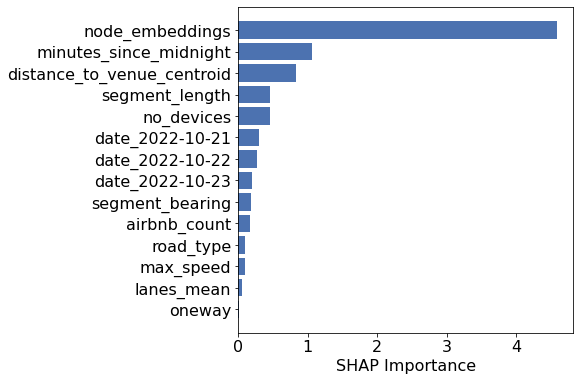

In [82]:
%%time
print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,6))

# Sort features by importance (descending order)
sorted_features = sorted(combined_importance.items(), key=lambda x: x[1], reverse=True)

# Extract sorted feature names and values
feature_names_sorted, feature_values_sorted = zip(*sorted_features)

# Plot sorted feature importances
plt.barh(range(len(feature_names_sorted)), feature_values_sorted, align='center', color="#4c72b0")
plt.yticks(range(len(feature_names_sorted)), feature_names_sorted)
plt.xlabel('SHAP Importance')
# plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Ensure the most important feature is at the top
plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')
# plt.show()

# shap_importance = shap_values.abs.mean(0).values
# sorted_idx = shap_importance.argsort()
# plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center',color="#4c72b0") #'turquoise'
# plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
# plt.xlabel('SHAP Importance')
# plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')

2024-12-13 12:09:42.617856 *************** Start running beeswarm ***************
CPU times: user 1min 31s, sys: 0 ns, total: 1min 31s
Wall time: 1min 29s


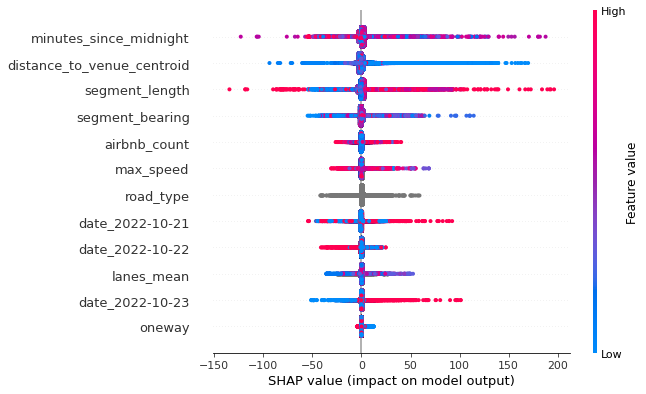

In [63]:
%%time
# ~6min
# Reading about gray colors: https://mlconference.ai/blog/tutorial-explainable-machine-learning-with-python-and-shap/
print(datetime.datetime.now(),'*************** Start running beeswarm ***************')
fig_beeswarm = shap.plots.beeswarm(shap_values,show=False, max_display=50)
plt.savefig('./output/shap_beeswarm.pdf', bbox_inches='tight')

In [64]:
X.columns

Index(['minutes_since_midnight', 'segment_length', 'segment_bearing', 'oneway', 'lanes_mean', 'road_type', 'max_speed', 'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23', 'airbnb_count', 'distance_to_venue_centroid'], dtype='object')

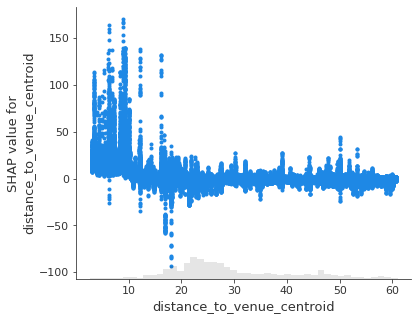

In [65]:
# Documentation: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html
shap.plots.scatter(shap_values[:, "distance_to_venue_centroid"])  #check distance_to_venue_centroid

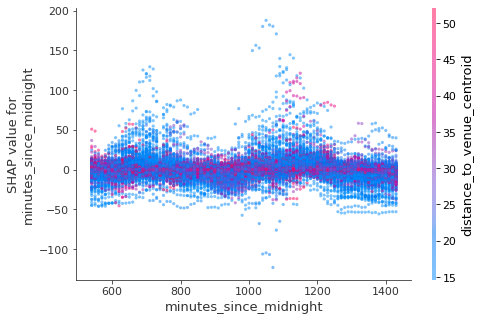

In [100]:
# shap.plots.scatter(shap_values[:, "minutes_since_midnight"])
shap.dependence_plot('minutes_since_midnight', shap_values.values, X, dot_size=10, alpha=0.5,
                               interaction_index='distance_to_venue_centroid', show=False)

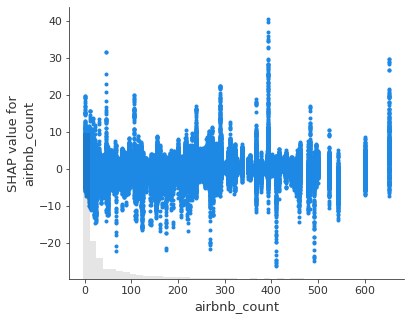

CPU times: user 7.96 s, sys: 0 ns, total: 7.96 s
Wall time: 7.79 s


In [104]:
%%time
shap.plots.scatter(shap_values[:, "airbnb_count"])
# shap.dependence_plot('airbnb_count', shap_values.values, X, dot_size=10, alpha=0.5,
#                                interaction_index='distance_to_venue_centroid', show=False)

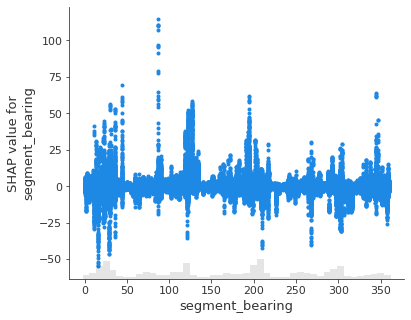

CPU times: user 8.4 s, sys: 0 ns, total: 8.4 s
Wall time: 8.23 s


In [70]:
%%time
shap.plots.scatter(shap_values[:, "segment_bearing"])

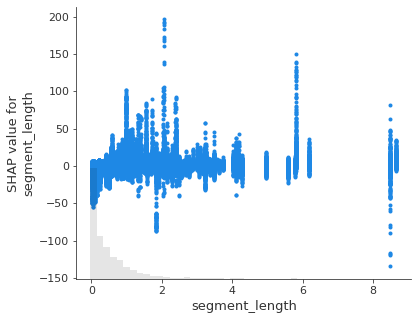

In [72]:
shap.plots.scatter(shap_values[:, "segment_length"])

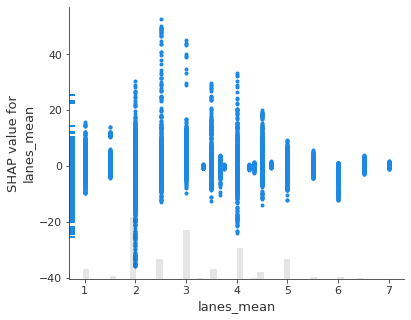

CPU times: user 8.82 s, sys: 0 ns, total: 8.82 s
Wall time: 8.67 s


In [71]:
%%time
shap.plots.scatter(shap_values[:, "lanes_mean"])

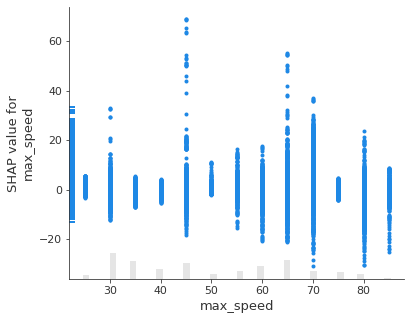

In [73]:
shap.plots.scatter(shap_values[:, "max_speed"])

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.32 s


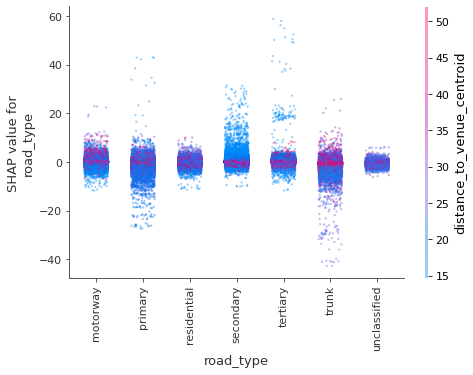

In [101]:
%%time
shap.dependence_plot('road_type', shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index='distance_to_venue_centroid', show=False, x_jitter=0.5)

In [126]:
# shap.plots.scatter(shap_values[:, "road_type"])

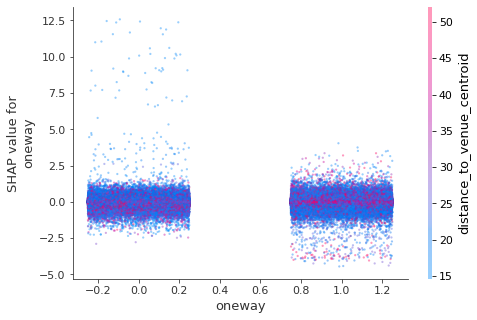

In [105]:
shap.dependence_plot('oneway', shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index='distance_to_venue_centroid', show=False, x_jitter=0.5)

# Spatial SHAP

In [75]:
df_shap_merged = df_traffic.merge(df_shape_values, ) #on=['tmc_code', 'minutes_since_midnight', 'date_2022-10-21','date_2022-10-22','date_2022-10-23']
print(df_shap_merged.shape[0])
df_shap_merged.head()

866449


tmc_code hour_min  delay_baseline  delay_focus  delay_difference         intersection  start_latitude  start_longitude  end_latitude  end_longitude  segment_length  airbnb_count  distance_to_venue_centroid  distance_to_Shuttle_Waterloo_Park  distance_to_Shuttle_Barton_Creek_Square  distance_to_Shuttle_Expo_Center  segment_bearing                                       osm_id  road_type  oneway       lanes maxspeed  lanes_mean  minutes_since_midnight  date_2022-10-21  date_2022-10-22  date_2022-10-23  max_speed  shap_minutes_since_midnight  shap_segment_length  shap_segment_bearing  shap_oneway  shap_lanes_mean  shap_road_type  shap_max_speed  shap_date_2022-10-21  shap_date_2022-10-22  shap_date_2022-10-23  shap_airbnb_count  shap_distance_to_venue_centroid
0  112+04760  09:00   -1.30941        -0.54871     0.76071            US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402      0.29287          49           26.64241                    7.39988                            14.41580                                 10.33789                         19.79829          [122981397, 1012363973]66847798019339769835  secondary  True    ['1', '2']  55 mph  1.50000      540                     1                0                0               55.00000   -0.21827                     -0.96356             -0.45418              -0.01172     -0.09461         0.34925         0.33935         0.45318               0.08170               0.01048               -0.16211           -0.77516                        
1  112+04760  09:10   0.00000         -1.77926     -1.77926           US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402      0.29287          49           26.64241                    7.39988                            14.41580                                 10.33789                         19.79829          [122981397, 1012363973]66847798019339769835  secondary  True    ['1', '2']  55 mph  1.50000      550                     1                0                0               55.00000   -0.16006                     -0.45093             -0.28606              -0.03561     -0.00280         0.21872         0.33367         0.37435               0.05931               0.01031               0.07095            -0.60821                        
2  112+04760  09:20   -0.54871        -1.77926     -1.23055           US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402      0.29287          49           26.64241                    7.39988                            14.41580                                 10.33789                         19.79829          [122981397, 1012363973]66847798019339769835  secondary  True    ['1', '2']  55 mph  1.50000      560                     1                0                0               55.00000   -0.30254                     -0.28288             -0.21448              -0.03393     -0.11840         0.07802         0.36938         0.29424               0.04249               -0.00366              0.06425            -0.56602                        
3  112+04760  09:30   -1.77926        -1.77926     0.00000            US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402      0.29287          49           26.64241                    7.39988                            14.41580                                 10.33789                         19.79829          [122981397, 1012363973]66847798019339769835  secondary  True    ['1', '2']  55 mph  1.50000      570                     1                0                0               55.00000   -0.56381                     -0.11521             -0.14709              -0.08472     0.01748          0.03209         0.43572         0.17208               -0.06494              -0.01464              -0.01100           -0.41267                        
4  112+04760  09:40   -1.54784        0.00000      1.54784            US-183/EXIT 239-240 30.32874        -97.70568        30.33272      -97.70402   

In [76]:
print('average prediction:', df_shap_merged.shap_minutes_since_midnight.mean())

average prediction: -0.003870122198600434


In [77]:
# Create a polygon for event venue
from shapely.geometry import Polygon
import geopandas as gpd

lat_point_list = [30.131962, 30.146337, 30.140386, 30.122629]
lon_point_list = [-97.647388, -97.635686, -97.619652, -97.631465]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       
polygon['name']  = 'the Circuit of the Americas'
polygon
# polygon.explore()

import shapely.geometry as geom

# Create Shapely point geometries
point_waterloo_park = geom.Point(-97.736285, 30.273726) # (longitude, latitude)
point_barton_creek_square = geom.Point(-97.805046, 30.257509)
point_expo_center = geom.Point(-97.622544, 30.297062)
point_ridehailing = geom.Point(-97.614135, 30.178718)

point_shuttle_list = [point_waterloo_park,point_barton_creek_square,point_expo_center,point_ridehailing]
gdf_shuttle = gpd.GeoDataFrame({'Shuttle_Location': ['Shuttle_Waterloo_Park', 'Shuttle_Barton_Creek_Square', 'Shuttle_Expo_Center', 'Uber_DelValle_HighSchool'],
                        'geometry': point_shuttle_list},
                        crs="EPSG:4326")
# gdf_shuttle

In [78]:
df_road = pd.read_csv("data/TMC_Identification.csv", sep=',', header=0)
df_road = df_road[['tmc_code','intersection','start_latitude','start_longitude','end_latitude','end_longitude','miles']]

from shapely.geometry import LineString
from geopandas import GeoDataFrame

df_road['geometry'] = df_road.apply(
    lambda row: LineString([(row['start_longitude'], row['start_latitude']),
                             (row['end_longitude'], row['end_latitude'])]),
    axis=1
)

# Create a GeoDataFrame
gdf_road = GeoDataFrame(df_road, geometry='geometry',crs="EPSG:4326")
print(gdf_road.shape[0])

4460


In [109]:
# Select one time point and plot the SHAP values of several features at that specfic time point
# hourmin_select, date_select = 600, 'date_2022-10-22' #1200
hourmin_select, date_select = 1200, 'date_2022-10-22' #1200
df_plotshap = df_shap_merged[(df_shap_merged['minutes_since_midnight'] == hourmin_select)&(df_shap_merged[date_select] == 1)]
# df_plotshap['shap_coordinates'] = df_plotshap['shap_start_latitude'] + df_plotshap['shap_start_longitude']
print(df_plotshap.shape[0])
print(gdf_road.shape[0])

gdf_road_merged = gdf_road.merge(df_plotshap,) #left_on='tmc', right_on='tmc_code'
print(gdf_road_merged.shape[0])
# gdf_road_merged.shap_coordinates.describe()

3221
4460
3098


In [110]:
gdf_road_merged.columns

Index(['tmc_code', 'intersection', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'miles', 'geometry', 'hour_min', 'delay_baseline', 'delay_focus', 'delay_difference', 'segment_length', 'airbnb_count', 'distance_to_venue_centroid', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center', 'segment_bearing', 'osm_id', 'road_type', 'oneway', 'lanes', 'maxspeed', 'lanes_mean', 'minutes_since_midnight', 'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23', 'max_speed', 'shap_minutes_since_midnight', 'shap_segment_length', 'shap_segment_bearing', 'shap_oneway', 'shap_lanes_mean', 'shap_road_type', 'shap_max_speed', 'shap_date_2022-10-21', 'shap_date_2022-10-22', 'shap_date_2022-10-23', 'shap_airbnb_count', 'shap_distance_to_venue_centroid'], dtype='object')

In [118]:
%%time
# 'shap_minutes_since_midnight', 'shap_segment_length', 'shap_segment_bearing', 'shap_oneway', 'shap_lanes_mean', 'shap_road_type', 
# 'shap_max_speed', 'shap_date_2022-10-21', 'shap_date_2022-10-22', 'shap_date_2022-10-23', 'shap_airbnb_count', 'shap_distance_to_venue_centroid'
# congestion_colors = ["#00FF00", "#ADFF2F", "#FFFF00", "#FFA500", "#FF0000", "#8B0000"]
shap_select = 'shap_oneway'
print('date:', date_select)
print('hour',hourmin_select/60)
print(shap_select)
m = gdf_road_merged.explore(
    column=shap_select,
    cmap= 'rainbow',
    tiles="CartoDB Positron", # OpenStreetMap, CartoDB dark_matter, CartoDB Positron
    categorical=False
)

m = gdf_shuttle.explore(
    m=m,
    markersize=40,
    linewidth=2,
    edgecolor="black",
)

polygon.explore(
    m=m
)

date: date_2022-10-22
hour 20.0
shap_oneway
CPU times: user 367 ms, sys: 0 ns, total: 367 ms
Wall time: 364 ms
